This is some agglomeration of pulling different files, testing stacking, and making sure images are centered, so I wouldn't recommend running all of this. 

In [2]:
import numpy as np
import pandas as pd
import subprocess
import os
import sys
import argparse
import glob
import time
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
from urllib.request import urlopen
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.time import Time
from contextlib import closing
from astropy import units as u



In [3]:
dataframe = pd.read_csv('ztf_transients.csv')

In [4]:
def create_npy_dataframe(folder_path):
    data = []
    
    # Loop over files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".npy"):
            file_path = os.path.join(folder_path, filename)
            
            # Extract metadata from the filename (example)
            # Let's assume filename format: name_epoch.npy (modify as needed)
            name = filename.split('_')[0]
            epoch = filename.split('_')[2]

        data.append({
                'Name': name,
                'Epoch': epoch,
                'File Path': file_path
                })
        
    df = pd.DataFrame(data)
    return df

starting_dataset = create_npy_dataframe('luminosity_arrays')

In [6]:
full_bts_catalogue = pd.read_csv('bts_survey_data2.txt')

In [5]:
def get_tiles():
    """ Get tiles 
    I ran wget https://archive-new.nrao.edu/vlass/VLASS_dyn_summary.php
    """
    fname = "VLASS_dyn_summary.php"
    inputf = open(fname, "r")
    lines = inputf.readlines()
    inputf.close()

    header = list(filter(None, lines[0].split("  ")))
    # get rid of white spaces
    header = np.array([val.strip() for val in header])

    names = []
    dec_min = []
    dec_max = []
    ra_min = []
    ra_max = []
    obsdate = []
    epoch = []

    # Starting at lines[3], read in values
    for line in lines[3:]:
        dat = list(filter(None, line.split("  "))) 
        dat = np.array([val.strip() for val in dat]) 
        names.append(dat[0])
        dec_min.append(float(dat[1]))
        dec_max.append(float(dat[2]))
        ra_min.append(float(dat[3]))
        ra_max.append(float(dat[4]))
        obsdate.append(dat[6])
        epoch.append(dat[5])

    names = np.array(names)
    dec_min = np.array(dec_min)
    dec_max = np.array(dec_max)
    ra_min = np.array(ra_min)
    ra_max = np.array(ra_max)
    obsdate = np.array(obsdate)
    epoch = np.array(epoch)

    return (names, dec_min, dec_max, ra_min, ra_max, epoch, obsdate)

def search_tiles(tiles, c):
    """ Now that you've processed the file, search for the given RA and Dec
    
    Parameters
    ----------
    c: SkyCoord object
    """
    ra_h = c.ra.hour
    dec_d = c.dec.deg
    names, dec_min, dec_max, ra_min, ra_max, epochs, obsdate = tiles
    has_dec = np.logical_and(dec_d > dec_min, dec_d < dec_max)
    has_ra = np.logical_and(ra_h > ra_min, ra_h < ra_max)
    in_tile = np.logical_and(has_ra, has_dec)
    name = names[in_tile]
    epoch = epochs[in_tile]
    date = obsdate[in_tile]
    if len(name) == 0:
        print("Sorry, no tile found.")
        return None, None, None
    else:
        return name, epoch, date

def search_tiles_and_sort(c):
    """
    Gets tiles and sorts the available epochs in order, returning tiles, epochs, and their observed dates
    """

    tiles = get_tiles()
    tilenames, epochs, obsdates = search_tiles(tiles, c)

    # Sort the tiles by the epochs so most recent goes last
    combined = list(zip(tilenames, epochs, obsdates))
    combined_sorted = sorted(combined, key=lambda x: x[1])
    tilenames, epochs, obsdates = zip(*combined_sorted)

    return tilenames, epochs, obsdates


def object_to_multiple_epochs(name, c):
    """
    Takes the list of lists from search_tiles_and_sort and makes them into separate dictionaries,
    each representing a unique epoch-date observed
    """

    object_lists = []
    set_list = search_tiles_and_sort(c)
    # get the length of the individual lists (how many epochs show up)
    for x in range(len(set_list[0])):
        obs = {'Name': name,
               'c': c,
               'Tile': set_list[0][x],
               'Epoch': set_list[1][x],
               'Date': set_list[2][x]}
        object_lists.append(obs)

    return object_lists

def dataframe_to_objects(dataframe, name_id_col = 'ZTFID', ra_id_col = 'RA', dec_id_col = 'Dec'):

    new_dataframe = []
    for i, object in dataframe.iterrows():
        name = object[name_id_col]
        coord_str = object[ra_id_col] + object[dec_id_col]
        c = SkyCoord(coord_str, unit=(u.hourangle, u.deg))
        object_data = {'Name': name,
                       'Skycoord': c}
        new_dataframe.append(object_data)
    return new_dataframe
        
def multiple_objects_to_event_list(dataframe, name_id_col = 'ZTFID', ra_id_col = 'RA', dec_id_col = 'Dec'):
    
    """ Given a pandas dataframe with name, ra, and dec, returns the a list of dictionaries
    which each have the name, skycoord, tile, epoch, and date of observation
    """

    final_object_epoch_list = []
    list_dict = dataframe_to_objects(dataframe, name_id_col, ra_id_col, dec_id_col)
    for obj in list_dict:
        name = obj['Name']
        c = obj['Skycoord']
        list_epoch_tiles = object_to_multiple_epochs(name, c)
        print(name)
        for x in list_epoch_tiles:
            final_object_epoch_list.append(x)

    return final_object_epoch_list

In [7]:
event_list = multiple_objects_to_event_list(dataframe)

ZTF17aaapufz
ZTF17aaazdba
ZTF17aabtvsy
ZTF17aacldgo
ZTF17aacpbmv
ZTF17aadlxmv
ZTF18aaaibml
ZTF18aaaonon
ZTF18aaaqexr
ZTF18aabcgyb
ZTF18aabdajx
ZTF18aabdgik
ZTF18aabkrky
ZTF18aabkvpi
ZTF18aabssth
ZTF18aabtxvd
ZTF18aabxlsv
ZTF18aaceepu
ZTF18aacemcn
ZTF18aacnlxz
ZTF18aadlaxo
ZTF18aadmssd
ZTF18aadsuxd
ZTF18aadxnul
ZTF18aadzfso
ZTF18aaegvyd
ZTF18aaeipng
ZTF18aaemivw
ZTF18aaeqjmc
ZTF18aaermez
ZTF18aaezzww
ZTF18aafdigb
ZTF18aafpfwr
ZTF18aafzers
ZTF18aagkwgz
ZTF18aagpzjk
ZTF18aagrdcs
ZTF18aagrtxs
ZTF18aagstdc
ZTF18aagtcxj
ZTF18aagtwyh
ZTF18aahatvc
ZTF18aahesrp
ZTF18aahfbqp
ZTF18aahfeiy
ZTF18aahfgyz
ZTF18aahfqbc
ZTF18aahfxnn
ZTF18aahfzea
ZTF18aahheaj
ZTF18aahhenr
ZTF18aahhqih
ZTF18aahhzqn
ZTF18aahjafd
ZTF18aahmhxu
ZTF18aahpbwz
ZTF18aahptcq
ZTF18aahqkbt
ZTF18aahqmsr
ZTF18aahrzkb
ZTF18aahshhp
ZTF18aahtjsc
ZTF18aahuujv
ZTF18aahvkwq
ZTF18aahvndq
ZTF18aahvpcy
ZTF18aahwhbk
ZTF18aaiiigm
ZTF18aailmnv
ZTF18aairuad
ZTF18aaisqmw
ZTF18aaisuxz
ZTF18aaisybp
ZTF18aaisyyp
ZTF18aaivnak
ZTF18aaiwewk
ZTF18aaiwzie

In [8]:
def normalize_epoch(epoch_str):
    """
    Converts the epoch string like 'VLASS1.1' to just the epoch number (1).
    """
    # Assuming epoch is always in the format 'VLASSx.y'
    epoch_number = epoch_str.split('VLASS')[1].split('.')[0]  # Get the 'x' part of 'VLASSx.y'
    return epoch_number

def update_dataframe_with_dates(dataframe, event_list):
    """
    Updates the DataFrame with the date from the event_list based on matching
    'Name' and 'Epoch' (normalized).
    """
    # Create a dictionary for easy lookup of dates by 'Name' and 'Epoch'
    date_lookup = {}
    for event in event_list:
        # Normalize the epoch (e.g., 'VLASS1.1' to '1')
        normalized_epoch = normalize_epoch(event['Epoch'])
        date_lookup[(event['Name'], normalized_epoch)] = event['Date']

    
    # Add a new 'Date' column to the DataFrame based on matching 'Name' and 'Epoch'
    dataframe['Date'] = dataframe.apply(lambda row: date_lookup.get((row['Name'], row['Epoch']), None), axis=1)
    
    return dataframe

In [9]:
update_dataframe_with_dates(starting_dataset, event_list)

Name Epoch                                       File Path  \
0      ZTF17aaapufz     1  luminosity_arrays\ZTF17aaapufz_epoch_1_lum.npy   
1      ZTF17aaapufz     2  luminosity_arrays\ZTF17aaapufz_epoch_2_lum.npy   
2      ZTF17aaapufz     3  luminosity_arrays\ZTF17aaapufz_epoch_3_lum.npy   
3      ZTF17aaazdba     1  luminosity_arrays\ZTF17aaazdba_epoch_1_lum.npy   
4      ZTF17aaazdba     2  luminosity_arrays\ZTF17aaazdba_epoch_2_lum.npy   
...             ...   ...                                             ...   
28852  ZTF24abjdahk     2  luminosity_arrays\ZTF24abjdahk_epoch_2_lum.npy   
28853  ZTF24abjdahk     3  luminosity_arrays\ZTF24abjdahk_epoch_3_lum.npy   
28854  ZTF24abjjeet     1  luminosity_arrays\ZTF24abjjeet_epoch_1_lum.npy   
28855  ZTF24abjjeet     2  luminosity_arrays\ZTF24abjjeet_epoch_2_lum.npy   
28856  ZTF24abjjeet     3  luminosity_arrays\ZTF24abjjeet_epoch_3_lum.npy   

             Date  
0      2017-11-24  
1      2020-09-06  
2      2023-02-12  
3      2019-04-14  
4      2021-12-13  
...           ...  
28852  2020-08-06  
28853  2023-05-13  
28854  2019-06-18  
28855  2021-11-24  
28856  2024-06-07  

[28857 rows x 4 columns]

In [10]:
from astropy.time import Time

def convert_dates_to_jd(df, date_column, new_col_name='JD'):
    """
    Converts dates in a specified column of a DataFrame to Julian Date (JD).
    Handles both 'YYYY-MM-DD' and ISO 8601 format timestamps.

    Parameters:
    - df: Pandas DataFrame containing the date column.
    - date_column: Column name with dates in 'YYYY-MM-DD' or ISO 8601 format.
    - new_col_name: Name for the new Julian Date column.

    Returns:
    - DataFrame with a new column containing Julian Dates.
    """
    if date_column not in df.columns:
        raise ValueError(f"Column '{date_column}' not found in DataFrame.")

    def to_jd(date):
        try:
            return Time(date, format='isot').jd  # 'isot' handles both formats
        except ValueError:
            try:
                return Time(date, format='iso').jd  # Fallback for stricter ISO formats
            except Exception:
                return None  # Assign None for invalid dates

    df[new_col_name] = df[date_column].apply(to_jd)
    return df


In [11]:
convert_dates_to_jd(full_bts_catalogue, 'discdate', 'StartJD')

ZTFID      IAUID                    discdate           RA  \
0      ZTF17aaaeqms  AT2023jkf  2023-05-25T02:51:57.285431  01:19:13.43   
1      ZTF17aaahrni  AT2016dxt     2016-04-20 06:27:21.000  05:21:41.58   
2      ZTF17aaaikab  AT2019bgj     2019-02-24 04:52:19.000  07:44:31.43   
3      ZTF17aaajnki  AT2022fmn                  2018-03-16  12:25:48.85   
4      ZTF17aaajowi          -                  2021-05-28  11:47:44.37   
...             ...        ...                         ...          ...   
18008  ZTF25aaittpf          -  2025-03-16T09:25:32.704179  15:02:57.18   
18009  ZTF25aaittqc          -  2025-03-09T11:39:47.788598  15:03:27.91   
18010  ZTF25aaiushx          -  2025-03-10T11:54:43.399823  15:37:28.33   
18011  ZTF25aaivcgm          -  2025-03-10T13:49:13.343486  20:42:46.54   
18012  ZTF25aaiycey          -  2025-03-10T19:07:12.973930  21:51:52.04   

               Dec    peakt peakfilt  peakmag peakabs  duration     rise  \
0      +31:46:26.1  2102.97        r  17.5839       -    18.001   12.004   
1      -04:11:10.4  1155.90        g  17.1049       -     7.667     0.86   
2      +48:26:30.4  1122.01        g  15.7679       -  >299.783   >294.2   
3      +33:32:48.6   462.05        r  17.8040       -   177.744  161.426   
4      +14:34:10.4  1362.73        r  18.9963       -    >5.611    2.651   
...            ...      ...      ...      ...     ...       ...      ...   
18008  +20:04:15.8  2750.88        g  18.9170       -     >6.93    >6.93   
18009  +10:36:12.6  2743.95        g  17.9056       -     >0.04    >0.04   
18010  +05:49:11.3  2750.86        g  17.2130       -      >6.9     >6.9   
18011  -01:58:23.1  2744.04        r  17.1059       -        >1       >0   
18012  +26:09:13.9  2745.04        r  18.3091       -        >0       >0   

         fade type redshift          b    A_V       StartJD  
0       5.997    -        - -30.726791  0.205  2.460090e+06  
1       6.807   CV        - -21.841960  0.827  2.457499e+06  
2       5.583   CV        -  28.472792  0.155  2.458539e+06  
3      16.318  AGN        -  81.532942  0.047  2.458194e+06  
4       >2.96    -        -  70.564727  0.127  2.459362e+06  
...       ...  ...      ...        ...    ...           ...  
18008      >0    -        -  59.151297  0.095  2.460751e+06  
18009      >0    -        -  54.836399  0.085  2.460744e+06  
18010      >0    -        -  45.176000  0.198  2.460745e+06  
18011      >1    -        - -25.531235  0.212  2.460745e+06  
18012      >0    -        - -21.404580  0.174  2.460745e+06  

[18013 rows x 17 columns]

In [13]:
df_catalogue = pd.read_csv('ztf_transients.csv')

# Ensure both columns are in the same format for merging
starting_dataset['Name'] = starting_dataset['Name'].astype(str)
df_catalogue['ZTFID'] = df_catalogue['ZTFID'].astype(str)
full_bts_catalogue['ZTFID'] = full_bts_catalogue['ZTFID'].astype(str)

# Merge with df_catalogue first to get redshift, RA, Dec, type
working_df = starting_dataset.merge(df_catalogue[['ZTFID', 'redshift', 'RA', 'Dec', 'type']], 
                                    left_on='Name', right_on='ZTFID', how='left')

# Drop redundant ZTFID column
working_df.drop(columns=['ZTFID'], inplace=True)

convert_dates_to_jd(working_df, 'Date')

c:\Users\Jack Pope\anaconda3\Lib\site-packages\astropy\time\formats.py:1626: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


Name Epoch                                       File Path  \
0      ZTF17aaapufz     1  luminosity_arrays\ZTF17aaapufz_epoch_1_lum.npy   
1      ZTF17aaapufz     2  luminosity_arrays\ZTF17aaapufz_epoch_2_lum.npy   
2      ZTF17aaapufz     3  luminosity_arrays\ZTF17aaapufz_epoch_3_lum.npy   
3      ZTF17aaazdba     1  luminosity_arrays\ZTF17aaazdba_epoch_1_lum.npy   
4      ZTF17aaazdba     2  luminosity_arrays\ZTF17aaazdba_epoch_2_lum.npy   
...             ...   ...                                             ...   
28852  ZTF24abjdahk     2  luminosity_arrays\ZTF24abjdahk_epoch_2_lum.npy   
28853  ZTF24abjdahk     3  luminosity_arrays\ZTF24abjdahk_epoch_3_lum.npy   
28854  ZTF24abjjeet     1  luminosity_arrays\ZTF24abjjeet_epoch_1_lum.npy   
28855  ZTF24abjjeet     2  luminosity_arrays\ZTF24abjjeet_epoch_2_lum.npy   
28856  ZTF24abjjeet     3  luminosity_arrays\ZTF24abjjeet_epoch_3_lum.npy   

             Date redshift           RA          Dec   type         JD  
0      2017-11-24  0.00261  12:35:52.28  +27:55:55.4    LBV  2458081.5  
1      2020-09-06  0.00261  12:35:52.28  +27:55:55.4    LBV  2459098.5  
2      2023-02-12  0.00261  12:35:52.28  +27:55:55.4    LBV  2459987.5  
3      2019-04-14    0.022  08:13:16.95  +22:38:53.9    TDE  2458587.5  
4      2021-12-13    0.022  08:13:16.95  +22:38:53.9    TDE  2459561.5  
...           ...      ...          ...          ...    ...        ...  
28852  2020-08-06    0.067  01:19:38.87  +07:07:41.4  SN Ia  2459067.5  
28853  2023-05-13    0.067  01:19:38.87  +07:07:41.4  SN Ia  2460077.5  
28854  2019-06-18     0.03  03:17:04.09  +47:07:15.2  SN Ia  2458652.5  
28855  2021-11-24     0.03  03:17:04.09  +47:07:15.2  SN Ia  2459542.5  
28856  2024-06-07     0.03  03:17:04.09  +47:07:15.2  SN Ia  2460468.5  

[28857 rows x 9 columns]

In [14]:


# Merge with ia_catalogue to get StartJD
working_df = working_df.merge(full_bts_catalogue[['ZTFID', 'StartJD']], 
                              left_on='Name', right_on='ZTFID', how='left')

# Drop redundant ZTFID column again
working_df.drop(columns=['ZTFID'], inplace=True)

In [15]:
working_df['delta_t'] = working_df['JD'] - working_df['StartJD']

In [16]:
c = 3e5  # Speed of light in km/s
H0 = 70  # Hubble constant in km/s/Mpc

# Ensure redshift is numeric
working_df['redshift'] = pd.to_numeric(working_df['redshift'], errors='coerce')

# Calculate Approximate Distance
working_df['Distance_Mpc'] = (c * working_df['redshift']) / H0

# Calculate Rest-Frame Time
working_df['Rest_DeltaT'] = working_df['delta_t'] / (1 + working_df['redshift'])



In [17]:
def process_file_for_rms(npy_array):

    try:
        # Load the NumPy array
        im = np.load(npy_array)

        # 3-sigma clipping (find the root mean square of values that are not above 3 standard deviations)
        rms_temp = np.ma.std(im)
        keep = np.ma.abs(im) <= 3 * rms_temp
        rms = np.ma.std(im[keep])

        return rms

    except Exception as e:
        print(f"An error occurred while processing the array: {e}")
        return None

In [18]:
def process_array_for_rms(npy_array):

    try:
        # Load the NumPy array
        im = npy_array

        # 3-sigma clipping (find the root mean square of values that are not above 3 standard deviations)
        rms_temp = np.ma.std(im)
        keep = np.ma.abs(im) <= 3 * rms_temp
        rms = np.ma.std(im[keep])

        return rms

    except Exception as e:
        print(f"An error occurred while processing the array: {e}")
        return None

In [19]:
working_df['redshift'] = pd.to_numeric(working_df['redshift'], errors='coerce')


working_df['RMS'] = working_df.apply(lambda row: process_file_for_rms(row['File Path']) if not np.isnan(row['redshift']) else None, axis=1)


c:\Users\Jack Pope\anaconda3\Lib\site-packages\numpy\ma\core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Jack Pope\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Jack Pope\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [20]:

working_df['RMS'] = working_df['RMS'].astype(float).round(2)  # Rounds to 4 decimal places


c:\Users\Jack Pope\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [21]:
final_df = working_df[['Name', 'Epoch', 'RA', 'Dec', 'type', 'redshift', 'Distance_Mpc', 'Rest_DeltaT', 'RMS', 'File Path']]

In [22]:
final_df

Name Epoch           RA          Dec   type  redshift  \
0      ZTF17aaapufz     1  12:35:52.28  +27:55:55.4    LBV   0.00261   
1      ZTF17aaapufz     2  12:35:52.28  +27:55:55.4    LBV   0.00261   
2      ZTF17aaapufz     3  12:35:52.28  +27:55:55.4    LBV   0.00261   
3      ZTF17aaazdba     1  08:13:16.95  +22:38:53.9    TDE   0.02200   
4      ZTF17aaazdba     2  08:13:16.95  +22:38:53.9    TDE   0.02200   
...             ...   ...          ...          ...    ...       ...   
28852  ZTF24abjdahk     2  01:19:38.87  +07:07:41.4  SN Ia   0.06700   
28853  ZTF24abjdahk     3  01:19:38.87  +07:07:41.4  SN Ia   0.06700   
28854  ZTF24abjjeet     1  03:17:04.09  +47:07:15.2  SN Ia   0.03000   
28855  ZTF24abjjeet     2  03:17:04.09  +47:07:15.2  SN Ia   0.03000   
28856  ZTF24abjjeet     3  03:17:04.09  +47:07:15.2  SN Ia   0.03000   

       Distance_Mpc  Rest_DeltaT           RMS  \
0         11.185714   595.465834  1.791953e+25   
1         11.185714  1609.818374  2.171773e+25   
2         11.185714  2496.504124  1.735639e+25   
3         94.285714    49.882583  2.164368e+27   
4         94.285714  1002.915851  1.557547e+27   
...             ...          ...           ...   
28852    287.142857 -1418.468317  1.503675e+28   
28853    287.142857  -471.889123  1.190765e+28   
28854    128.571429 -1871.189995  2.625084e+27   
28855    128.571429 -1007.112325  2.422647e+27   
28856    128.571429  -108.083198  2.530941e+27   

                                            File Path  
0      luminosity_arrays\ZTF17aaapufz_epoch_1_lum.npy  
1      luminosity_arrays\ZTF17aaapufz_epoch_2_lum.npy  
2      luminosity_arrays\ZTF17aaapufz_epoch_3_lum.npy  
3      luminosity_arrays\ZTF17aaazdba_epoch_1_lum.npy  
4      luminosity_arrays\ZTF17aaazdba_epoch_2_lum.npy  
...                                               ...  
28852  luminosity_arrays\ZTF24abjdahk_epoch_2_lum.npy  
28853  luminosity_arrays\ZTF24abjdahk_epoch_3_lum.npy  
28854  luminosity_arrays\ZTF24abjjeet_epoch_1_lum.npy  
28855  luminosity_arrays\ZTF24abjjeet_epoch_2_lum.npy  
28856  luminosity_arrays\ZTF24abjjeet_epoch_3_lum.npy  

[28857 rows x 10 columns]

In [23]:
final_df['File Path'] = final_df['File Path'].str.replace(r'^luminosity_arrays\\', r'luminosity_arrays_2_april\\', regex=True)

final_df

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_10504\2270327430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['File Path'] = final_df['File Path'].str.replace(r'^luminosity_arrays\\', r'luminosity_arrays_2_april\\', regex=True)


Name Epoch           RA          Dec   type  redshift  \
0      ZTF17aaapufz     1  12:35:52.28  +27:55:55.4    LBV   0.00261   
1      ZTF17aaapufz     2  12:35:52.28  +27:55:55.4    LBV   0.00261   
2      ZTF17aaapufz     3  12:35:52.28  +27:55:55.4    LBV   0.00261   
3      ZTF17aaazdba     1  08:13:16.95  +22:38:53.9    TDE   0.02200   
4      ZTF17aaazdba     2  08:13:16.95  +22:38:53.9    TDE   0.02200   
...             ...   ...          ...          ...    ...       ...   
28852  ZTF24abjdahk     2  01:19:38.87  +07:07:41.4  SN Ia   0.06700   
28853  ZTF24abjdahk     3  01:19:38.87  +07:07:41.4  SN Ia   0.06700   
28854  ZTF24abjjeet     1  03:17:04.09  +47:07:15.2  SN Ia   0.03000   
28855  ZTF24abjjeet     2  03:17:04.09  +47:07:15.2  SN Ia   0.03000   
28856  ZTF24abjjeet     3  03:17:04.09  +47:07:15.2  SN Ia   0.03000   

       Distance_Mpc  Rest_DeltaT           RMS  \
0         11.185714   595.465834  1.791953e+25   
1         11.185714  1609.818374  2.171773e+25   
2         11.185714  2496.504124  1.735639e+25   
3         94.285714    49.882583  2.164368e+27   
4         94.285714  1002.915851  1.557547e+27   
...             ...          ...           ...   
28852    287.142857 -1418.468317  1.503675e+28   
28853    287.142857  -471.889123  1.190765e+28   
28854    128.571429 -1871.189995  2.625084e+27   
28855    128.571429 -1007.112325  2.422647e+27   
28856    128.571429  -108.083198  2.530941e+27   

                                               File Path  
0      luminosity_arrays_2_april\ZTF17aaapufz_epoch_1...  
1      luminosity_arrays_2_april\ZTF17aaapufz_epoch_2...  
2      luminosity_arrays_2_april\ZTF17aaapufz_epoch_3...  
3      luminosity_arrays_2_april\ZTF17aaazdba_epoch_1...  
4      luminosity_arrays_2_april\ZTF17aaazdba_epoch_2...  
...                                                  ...  
28852  luminosity_arrays_2_april\ZTF24abjdahk_epoch_2...  
28853  luminosity_arrays_2_april\ZTF24abjdahk_epoch_3...  
28854  luminosity_arrays_2_april\ZTF24abjjeet_epoch_1...  
28855  luminosity_arrays_2_april\ZTF24abjjeet_epoch_2...  
28856  luminosity_arrays_2_april\ZTF24abjjeet_epoch_3...  

[28857 rows x 10 columns]

In [73]:
final_df.to_csv('full_data_april.csv', index = False)

In [3]:
final_df = pd.read_csv('full_data2.csv')

*Here is where we can run stacking*

In [4]:
def weighted_stack(df):
    weighted_sum = None
    total_weight = 0

    for _, row in df.iterrows():
        file_path = row['File Path']
        rms = row['RMS']

        # Ensure file exists and RMS is valid
        if not isinstance(file_path, str) or not os.path.exists(file_path) or rms is None or rms <= 0 or np.isnan(rms):
            continue

        # Load the array and check its shape
        array = np.load(file_path)

        # Compute weight and accumulate
        weight = 1 / (rms ** 2)
        weighted_sum = array * weight if weighted_sum is None else weighted_sum + array * weight
        total_weight += weight

    # Normalize to get the final stacked array
    return None if total_weight == 0 else weighted_sum / total_weight


In [5]:
ia_df = final_df[final_df['type'].str.contains('SN Ia', na=False)]

tde_df = final_df[final_df['type'] == 'TDE']

In [218]:
tde_array = weighted_stack(tde_df)

In [373]:
ia_df_after = ia_df[ia_df['Rest_DeltaT'] >= 0]

In [377]:
after_array = weighted_stack(ia_df_after)

In [201]:
# Define time bins
time_bins = [(0, 100), (100, 300), (100, 200), (200, 600), (600, 800), (800, 1500)]

# Dictionary to store results
stacked_results = {}

for t_min, t_max in time_bins:
    subset_df = ia_df[(ia_df['Rest_DeltaT'] >= t_min) & (ia_df['Rest_DeltaT'] < t_max)]
    
    if not subset_df.empty:
        stacked_array = weighted_stack(subset_df)
        stacked_results[f"{t_min}-{t_max} days"] = stacked_array
    else:
        stacked_results[f"{t_min}-{t_max} days"] = None  # No data in this range

# Now you can check stacked_results for different time bins


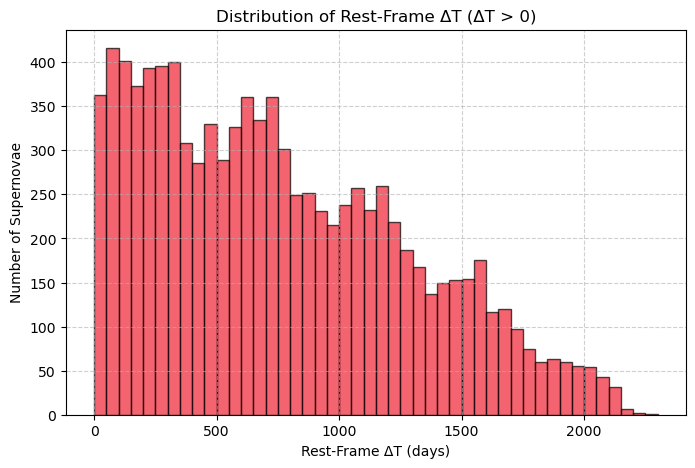

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Filter only positive values of Rest_DeltaT
valid_deltas = ia_df[ia_df['Rest_DeltaT'] > 0]['Rest_DeltaT'].dropna()

# Define bin edges with a step of 50 days
bin_edges = np.arange(0, valid_deltas.max() + 50, 50)

# Create histogram with the custom bin edges
plt.figure(figsize=(8, 5))
plt.hist(valid_deltas, bins=bin_edges, color = "#F02233", edgecolor='black', alpha=0.7)
plt.xlabel("Rest-Frame ΔT (days)")
plt.ylabel("Number of Supernovae")
plt.title("Distribution of Rest-Frame ΔT (ΔT > 0)")
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()



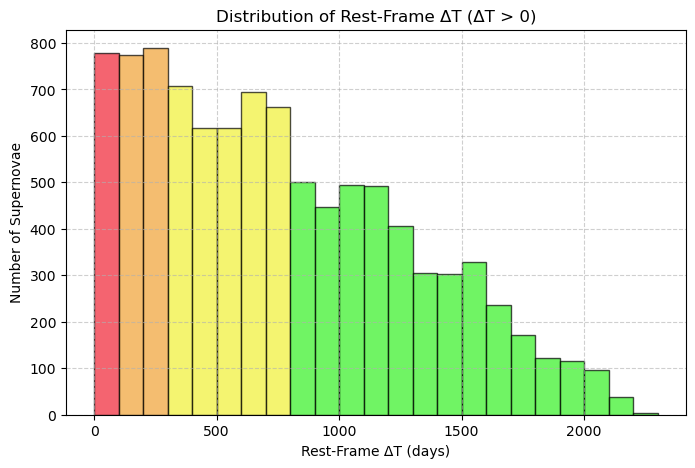

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Filter only positive values of Rest_DeltaT
valid_deltas = ia_df[ia_df['Rest_DeltaT'] > 0]['Rest_DeltaT'].dropna()

# Define bin edges with a step of 50 days
bin_edges = np.arange(0, valid_deltas.max() + 100, 100)

# Define the manual groups as (min, max) tuples
groups = [
    (0, 100),    # 1-100 days
    (100, 300),  # 100-300 days
    (300, 800),  # 300-800 days
    (800, 2500)] # 800-2500 days

# Create histogram with the custom bin edges
plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(valid_deltas, bins=bin_edges, edgecolor='black', alpha=0.7)

# Iterate over the bins and color them based on the group they belong to
for i, patch in enumerate(patches):
    bin_start = bins[i]
    bin_end = bins[i + 1]
    
    # Determine the color based on which group the bin belongs to
    color = 'gray'  # Default color
    for group in groups:
        if bin_start >= group[0] and bin_end <= group[1]:
            if group == (0, 100):
                color = '#F02233'  # Red
            elif group == (100, 300):
                color = '#F0A233'  # Orange
            elif group == (300, 800):
                color = '#F0F033'  # Yellow
            elif group == (800, 2500):
                color = '#33F022'  # Green
            break
    
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel("Rest-Frame ΔT (days)")
plt.ylabel("Number of Supernovae")
plt.title("Distribution of Rest-Frame ΔT (ΔT > 0)")
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()



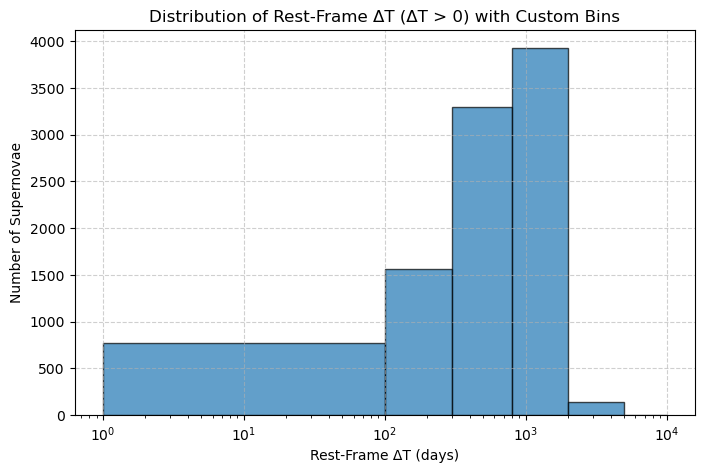

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Filter only positive values of Rest_DeltaT
valid_deltas = ia_df[ia_df['Rest_DeltaT'] > 0]['Rest_DeltaT'].dropna()

# Define custom bin edges (in days)
bins = [1, 100, 300, 800, 2000, 5000, 10000]  # Adjust these ranges as needed

# Create histogram with custom bin edges
plt.figure(figsize=(8, 5))
plt.hist(valid_deltas, bins=bins, edgecolor='black', alpha=0.7)

plt.xscale('log')

# Set labels and title
plt.xlabel("Rest-Frame ΔT (days)")
plt.ylabel("Number of Supernovae")
plt.title("Distribution of Rest-Frame ΔT (ΔT > 0) with Custom Bins")
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()



In [294]:
stacked_results.keys()

dict_keys(['0-100 days', '100-300 days', '100-200 days', '200-600 days', '600-800 days', '800-1500 days'])

In [279]:
process_array_for_rms(stacked_results['800-1500 days'])

3.563795021469181e+24

In [65]:
working_df.iloc[90]

Name                                           ZTF18aaezzww
Epoch                                                     1
File Path    luminosity_arrays\ZTF18aaezzww_epoch_1_lum.npy
Date                                             2019-04-13
JD                                                2458586.5
redshift                                            0.02520
ZTFID                                          ZTF18aaezzww
StartJD                                      2460187.006944
Name: 90, dtype: object

---------------------------------
Check Images

In [301]:
def luminosity_image_from_array(array, name, epoch):
    try:
        # Ensure the array is 2D
        if array.ndim != 2:
            print(f"Error: The input array for {name}, Epoch {epoch} must be 2D.")
            return None

        # Compute robust min/max values for better scaling
        vmin, vmax = np.percentile(array, [2, 99])  # Exclude extreme outliers
        # Ensure a reasonable contrast
        if vmin == vmax:
            vmin, vmax = np.min(array), np.max(array)

        # Compute RMS using 3-sigma clipping
        rms_temp = np.std(array)
        keep = np.abs(array) <= 3 * rms_temp
        rms = np.std(array[keep])

        # Find peak flux
        peak_flux = np.max(array)

        # Plot image with adjusted scaling
        fig, ax = plt.subplots(figsize=(6, 6))
        img = ax.imshow(np.flipud(array), cmap='YlOrRd', vmin=vmin, vmax=vmax)

        # Format the title
        peakstr = f"Peak Flux: {np.round(peak_flux, 3)}"
        rmsstr = f"RMS Flux: {np.round(rms, 3)}"

        title_str = r'$\bf{%s}$' % epoch + '\n' + f'{name}; {peakstr}; {rmsstr}'
        ax.set_title(title_str, fontsize=10)

        ax.set_xlabel("Offset in RA (arcsec)")
        ax.set_ylabel("Offset in Dec (arcsec)")
        ax.set_aspect('equal')  # Keep square aspect ratio

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {name}, Epoch {epoch}: {e}")
        return None


import numpy as np
import matplotlib.pyplot as plt

def highlight_image_from_array(array, name, epoch):
    try:
        # Ensure the array is 2D
        if array.ndim != 2:
            print(f"Error: The input array for {name}, Epoch {epoch} must be 2D.")
            return None

        # Compute RMS using 3-sigma clipping
        rms_temp = np.std(array)
        keep = np.abs(array) <= 3 * rms_temp
        rms = np.std(array[keep])

        # Find peak flux and its coordinates
        peak_flux = np.max(array)

        # Plot image with a simple color scale
        fig, ax = plt.subplots(figsize=(6, 6))
        img = ax.imshow(np.flipud(array), cmap='inferno')  # Inferno colormap for good contrast

        # Format the title
        peakstr = f"Peak Flux: {np.round(peak_flux, 3)}"
        rmsstr = f"RMS Flux: {np.round(rms, 3)}"
        title_str = r'$\bf{%s}$' % epoch + '\n' + f'{name}; {peakstr}; {rmsstr}'
        ax.set_title(title_str, fontsize=10)

        ax.set_xlabel("Offset in RA (arcsec)")
        ax.set_ylabel("Offset in Dec (arcsec)")
        ax.set_aspect('equal')  # Keep square aspect ratio

        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {name}, Epoch {epoch}: {e}")
        return None

In [316]:
def image_from_array(array, name, epoch):
    try:
        # Ensure the array is 2D
        if array.ndim != 2:
            print(f"Error: The input array for {name}, Epoch {epoch} must be 2D.")
            return None

        # Get image size
        ny, nx = array.shape  # Should be 12x12

        # Plot image with adjusted scaling
        fig, ax = plt.subplots(figsize=(6, 6))
        img = ax.imshow(array, cmap='viridis', origin='lower')

        # Format the title
        title_str = f'{name}, Epoch {epoch}'
        ax.set_title(title_str, fontsize=10)

        # Set pixel labels, but only a few (1, 6, 12)
        tick_positions = [0, nx//2, nx-1]  # Corresponds to pixels 1, 6, 12
        tick_labels = [0, 7, 13]

        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels)

        # Label axes as pixel indices
        ax.set_xlabel("Pixel Index (RA Offset)")
        ax.set_ylabel("Pixel Index (Dec Offset)")
        ax.set_aspect('equal')  # Keep square aspect ratio

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {name}, Epoch {epoch}: {e}")
        return None

In [389]:
np.load('luminosity_arrays/ZTF18acpdvos_epoch_3_lum.npy')

array([[-8.63376420e+27, -3.27339758e+27, -1.90934788e+27,
         1.63841004e+27, -9.22975475e+26, -1.24462577e+26,
         7.23434115e+27, -5.11179017e+26, -8.58198689e+27,
        -4.52802408e+27,  1.05277060e+28, -1.22365112e+26,
         6.06562015e+25],
       [-4.48060257e+27, -4.64823242e+27, -3.47957450e+27,
        -8.12886260e+26,  2.16896070e+27,  4.51719813e+27,
         1.91574668e+28,  1.98403659e+25, -1.33795934e+28,
        -4.37861919e+26,  9.57637995e+27, -1.49954160e+27,
        -3.59303807e+26],
       [-3.79192700e+27,  1.01735770e+27,  8.01625198e+27,
         9.76825759e+27,  1.90802824e+28,  3.45069812e+28,
         4.06521324e+28,  8.46070749e+27, -2.96397469e+27,
         5.88788049e+27,  7.87674218e+27, -1.89372992e+27,
         2.37483299e+27],
       [-1.29842587e+28, -1.05851352e+28,  3.34820247e+27,
         1.34146979e+28,  8.17903054e+28,  1.57449472e+29,
         1.25872364e+29,  4.30053419e+28,  6.95659826e+27,
         7.42844852e+27,  3.48428943e

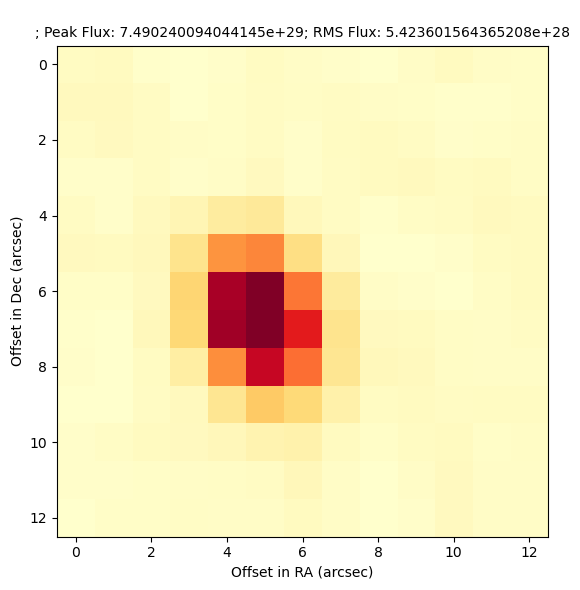

In [ ]:
luminosity_image_from_array(np.load('luminosity_arrays/ZTF18acpdvos_epoch_3_lum.npy'), '','')

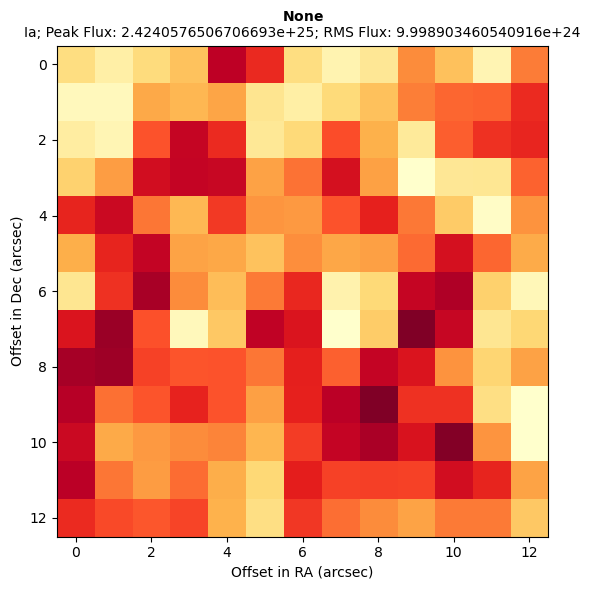

In [366]:
luminosity_image_from_array(stacked_results['0-100 days'], 'Ia', 'None')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_19220\1212664209.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


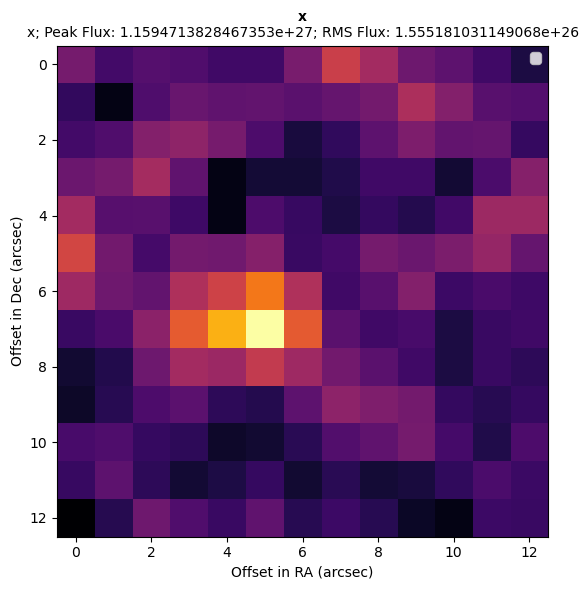

In [340]:
highlight_image_from_array(tde_array,'x', 'x')

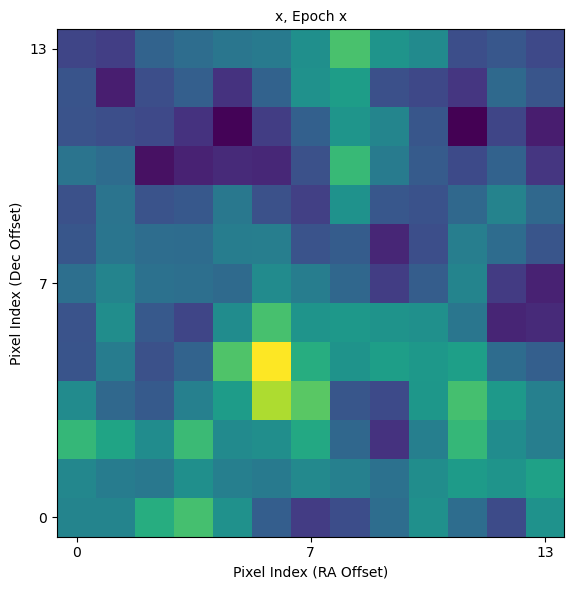

In [318]:
image_from_array(ia_array,'x', 'x')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_19220\1212664209.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


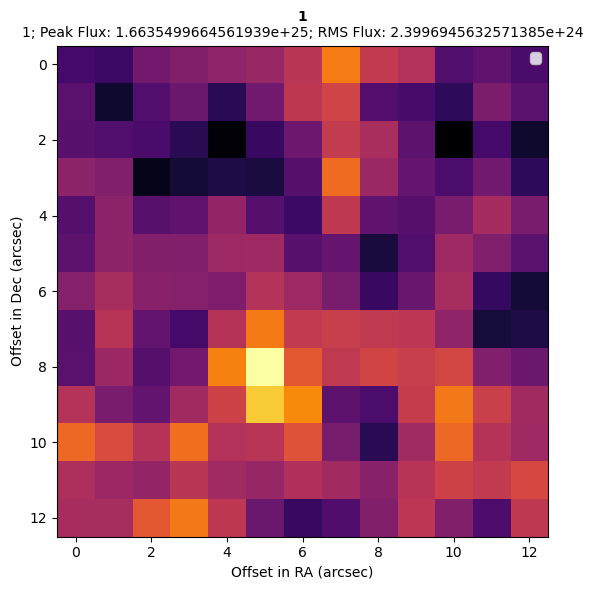

In [312]:
highlight_image_from_array(ia_array, '1', '1')

---------------------------------------


In [9]:
def get_coords_from_name(df, name):
    
    ra, dec = df.loc[df["ZTFID"] == name, ["RA", "Dec"]].values[0]
    c = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

    return c


In [10]:
def get_redshift(df, name):
    try:
        # Attempt to find the redshift value and convert it to a float
        result = df.loc[df["ZTFID"] == name, "redshift"].iloc[0]
        # If the result is a valid number, return it as a float
        return float(result)
    except (IndexError, ValueError):
        # If there is an error (e.g., value is missing or cannot be converted), return None
        return None

In [11]:
get_redshift(dataframe, 'ZTF17aaapufz')

0.00261

In [ ]:
normal_array = np.load('D:\summer_research_code\Query_VLASS_2\ia_npy_arrays\ZTF17aabtvsy_VLASS1.2v2_array.npy')

In [12]:
def redshift_to_distance(redshift, H0=70):
    """
    Convert redshift to comoving distance using Hubble's Law.

    Parameters:
    - redshift (float): The redshift value.
    - H0 (float): Hubble constant in km/s/Mpc (default: 70).

    Returns:
    - float: Distance in Megaparsecs (Mpc).
    """
    c = 3.0e5  # Speed of light in km/s
    return (c *redshift) / H0  # Distance in Mpc

In [16]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord

def dillon_get_numpy_array(local_fits_path, c):
    """
    Given a FITS path of a 31 by 31 arcsecond cutout, extracts a cutout centered on SkyCoord object `c`,
    """

    # Source coordinates
    ra_deg = c.ra.deg
    dec_deg = c.dec.deg

    try:
        # Open the FITS file
        with fits.open(local_fits_path) as hdul:
            im = hdul[0].data  # Read the image data
            
            if im.shape != (31, 31):
                print(f"Warning: The image in {local_fits_path} is not 31x31. It is {im.shape}.")
                # Optionally, you can resize the image or raise an error here
                return None

            im_plot_raw = im[8:21, 8:21]
            im_plot = np.ma.masked_invalid(im_plot_raw)

            return im_plot

    except Exception as e:
        print(f"An error occurred while processing {local_fits_path}: {e}")
        return None


In [396]:
dillon_get_numpy_array('dillon_fits/ztf_cutouts/ztf_cutouts_no_interp/ZTF17aabtvsy_epoch_1.fits',
                       get_coords_from_name(pd.read_csv('ztf_transients.csv'), 'ZTF17aabtvsy'))

masked_array(
  data=[[-2.61084278463386e-06, 3.0517960112774745e-05,
         0.00017778106848709285, 8.153684757417068e-05,
         -9.67968298937194e-05, -0.00016654479259159416,
         -0.00019408654770813882, -0.00010255378583678976,
         0.00016320194117724895, 0.00031044456409290433,
         1.5040129255794454e-05, -0.00016355606203433126,
         -0.00020328036043792963],
        [-1.3441325791063718e-05, -5.938288722973084e-07,
         -4.31381085945759e-05, -0.0001407937379553914,
         -3.7019442970631644e-05, 9.345427679363638e-05,
         0.00011398690548958257, 0.00010161662066821009,
         0.00011410652950871736, 0.00016015063738450408,
         -2.4379860406043008e-05, -0.00026848455308936536,
         -0.00026475609047338367],
        [4.995402377971914e-06, -8.719479228602722e-05,
         -5.366483310353942e-05, -0.00015588071255479008,
         -0.0001253075315617025, 9.056976705323905e-05,
         0.00011559756967471913, 1.3157260582374875e-05,
  

In [270]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord

def get_numpy_array(local_fits_path, c):
    """
    Given a FITS path, extracts a cutout centered on SkyCoord object `c`,
    using CRVAL1 and CRVAL2 instead of WCS.
    """

    # Source coordinates
    ra_deg = c.ra.deg
    dec_deg = c.dec.deg

    try:
        # Open the FITS file
        with fits.open(local_fits_path) as hdul:
            im = hdul[0].data  # Read the image data
            header = hdul[0].header  # Read the FITS header

            # Get the reference position in degrees
            crval1 = header['CRVAL1']  # Reference RA
            crval2 = header['CRVAL2']  # Reference Dec
            crpix1 = header['CRPIX1']  # Reference pixel X 
            crpix2 = header['CRPIX2'] # Reference pixel Y
            

            # Compute pixel position manually
            # 1 arcsecond per pixel -> 1 degree = 3600 pixels
            x = crpix1 + (ra_deg - crval1) * 3600
            y = crpix2 + (dec_deg - crval2) * 3600

            # Set the dimensions of the cutout (13 arcseconds per side)
            cutout_size_pix = 13  # 13 arcseconds = 13 pixels
            half_size_pix = cutout_size_pix // 2

            # Extract the cutout
            im_plot_raw = im[int(x - half_size_pix):int(x + half_size_pix + 1),
                             int(y - half_size_pix):int(y + half_size_pix + 1)]
            im_plot = np.ma.masked_invalid(im_plot_raw)

            return im_plot

    except Exception as e:
        print(f"An error occurred while processing {local_fits_path}: {e}")
        return None

In [4]:
def calculate_luminosity(flux, distance_mpc):
    """
    Calculate luminosity from flux and distance.

    Parameters:
    - flux (float or np.ndarray): Flux in Janskys.
    - distance_mpc (float): Distance in Megaparsecs.

    Returns:
    - np.ndarray: Luminosity in erg/s/Hz.
    """
    # Constants
    MPC_TO_CM = 3.0857e24  # 1 Mpc to cm
    JY_TO_ERG = 1e-23  # Jansky to erg/s/cm²/Hz
    FOUR_PI = 4 * np.pi

    # Convert flux to erg/s/cm²/Hz
    flux_erg = flux * JY_TO_ERG

    # Convert distance to cm
    distance_cm = distance_mpc * MPC_TO_CM

    # Calculate luminosity
    luminosity = FOUR_PI * (distance_cm ** 2) * flux_erg
    return luminosity

In [5]:
def fits_to_luminosity_array(name, fits_file, df):

    c = get_coords_from_name(df, name)
    redshift = get_redshift(df, name)
    if redshift is not None:
        dist_mpc = redshift_to_distance(redshift)
        return calculate_luminosity(dillon_get_numpy_array(fits_file, c), dist_mpc), dist_mpc
    else:
        print(f'Could not convert {fits_file} to luminosity since no redshift available')
        return None, None

In [22]:
def process_fits_files(df, input_folder = 'dillon_fits\ztf_cutouts\ztf_cutouts_no_interp',
                       output_folder = 'luminosity_arrays_2_april'):
    
    fails = []
    for file_name in os.listdir(input_folder):

        if file_name.startswith("._"):
            continue

        print(f'Working on {file_name}')
        name = file_name.split('_')[0]
        fits_file = os.path.join(input_folder, file_name)
        luminosity, dist_mpc = fits_to_luminosity_array(name, fits_file, df)
        if luminosity is not None:
            luminosity_array = luminosity.filled(np.nan)
            output_file_name = file_name.replace('.fits', '_lum.npy')
            output_file_path = os.path.join(output_folder, output_file_name)
            if not os.path.exists(output_file_path):
                np.save(output_file_path, luminosity_array)
                print(f'Saved {output_file_path}')
        else:
            fails.append(fits_file)

    return set(fails)


goob = process_fits_files(dataframe)

<>:1: SyntaxWarning: invalid escape sequence '\z'
<>:1: SyntaxWarning: invalid escape sequence '\z'
C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_17904\2551339867.py:1: SyntaxWarning: invalid escape sequence '\z'
  def process_fits_files(df, input_folder = 'dillon_fits\ztf_cutouts\ztf_cutouts_no_interp',


Working on ZTF17aaapufz_epoch_1.fits
Working on ZTF17aaapufz_epoch_2.fits
Working on ZTF17aaapufz_epoch_3.fits
Working on ZTF17aaazdba_epoch_1.fits
Working on ZTF17aaazdba_epoch_2.fits
Working on ZTF17aaazdba_epoch_3.fits
Working on ZTF17aabtvsy_epoch_1.fits
Working on ZTF17aabtvsy_epoch_2.fits
Working on ZTF17aabtvsy_epoch_3.fits
Working on ZTF17aacldgo_epoch_1.fits
Working on ZTF17aacldgo_epoch_2.fits
Working on ZTF17aacldgo_epoch_3.fits
Working on ZTF17aacpbmv_epoch_1.fits
Working on ZTF17aacpbmv_epoch_2.fits
Working on ZTF17aacpbmv_epoch_3.fits
Working on ZTF17aadlxmv_epoch_1.fits
Working on ZTF17aadlxmv_epoch_2.fits
Working on ZTF17aadlxmv_epoch_3.fits
Working on ZTF18aaaibml_epoch_1.fits
Working on ZTF18aaaibml_epoch_2.fits
Working on ZTF18aaaibml_epoch_3.fits
Working on ZTF18aaaonon_epoch_1.fits
Working on ZTF18aaaonon_epoch_2.fits
Working on ZTF18aaaonon_epoch_3.fits
Working on ZTF18aaaqexr_epoch_1.fits
Working on ZTF18aaaqexr_epoch_2.fits
Working on ZTF18aaaqexr_epoch_3.fits
W

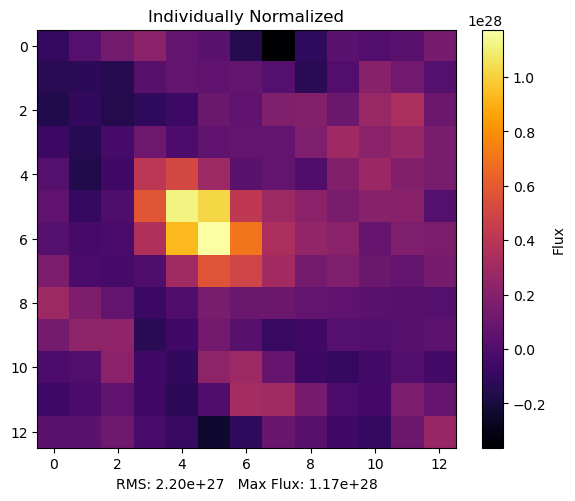

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_single_array_npy(npy_path, cmap='inferno'):
    """
    Plots a single 2D array from a .npy file with individual color scaling.

    Parameters:
    - npy_path: Path to the .npy file containing a single 2D array.
    - cmap: Colormap for visualization (default: 'inferno').
    """
    arr = np.load(npy_path)

    plt.figure(figsize=(6, 5))
    plt.imshow(arr, cmap=cmap, vmin=arr.min(), vmax=arr.max())
    plt.colorbar(label='Flux')
    plt.title("Individually Normalized")
    plt.xlabel(f"RMS: {np.std(arr):.2e}   Max Flux: {arr.max():.2e}")
    plt.tight_layout()
    plt.show()

plot_single_array_npy('luminosity_arrays/ZTF17aaazdba_epoch_2_lum.npy')


<>:1: SyntaxWarning: invalid escape sequence '\Z'
<>:1: SyntaxWarning: invalid escape sequence '\Z'
C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_17904\1985075375.py:1: SyntaxWarning: invalid escape sequence '\Z'
  plot_single_array_npy('luminosity_arrays_2_april\ZTF17aaazdba_epoch_2_lum.npy')


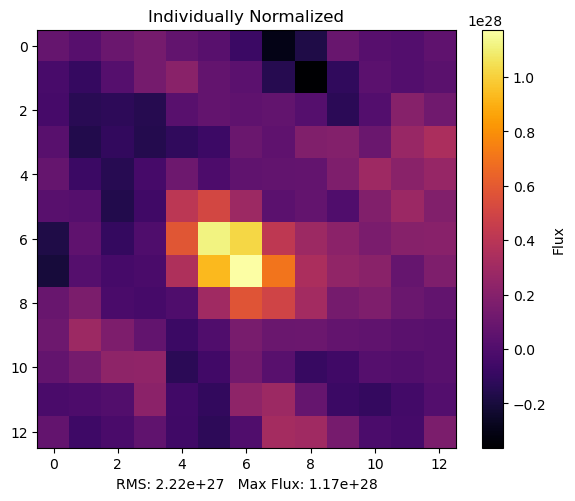

In [21]:
plot_single_array_npy('luminosity_arrays_2_april\ZTF17aaazdba_epoch_2_lum.npy')

In [247]:
def luminosity_image_from_npy(npy_file, name, epoch, distance):
    try:
        # Load the image array from the .npy file
        im = np.load(npy_file)
        
        # Verify that the array is 2D
        if im.ndim != 2:
            print("Error: The input array must be 2D.")
            return None

        # 3-sigma clipping (find root mean square of values that are not above 3 standard deviations)
        rms_temp = np.ma.std(im)
        keep = np.ma.abs(im) <= 3 * rms_temp
        rms = np.ma.std(im[keep])

        # Find peak flux in entire image
        peak_flux = np.ma.max(im)

        # Plot the image (no need for WCS)
        fig, ax = plt.subplots(figsize=(6, 6))  # Create a square figure
        vmin = calculate_luminosity(-1e-4, distance)
        vmax = calculate_luminosity(1e-3, distance)
        ax.imshow(np.flipud(im), cmap='YlOrRd', vmin=vmin, vmax=vmax)
        print(f"vmin = {vmin}, vmax = {vmax}")

        peakstr = "Peak Flux %s " % (np.round(peak_flux, 3))
        rmsstr = "RMS Flux %s " % (np.round(rms, 3))

        title_str = r'$\bf{%s}$' % epoch + '\n' + '%s: %s;\n%s' % (name, peakstr, rmsstr)
        ax.set_title(title_str, fontsize=10)
        ax.set_xlabel("Offset in RA (arcsec)")
        ax.set_ylabel("Offset in Dec (arcsec)")

        ax.set_aspect('equal')  # Ensure the plot is square
        ax.figure.tight_layout()  # Adjust layout to fit everything nicely

    except Exception as e:
        print(f"An error occurred while processing {npy_file}: {e}")
        return None


In [248]:
# check arrays here:
def image_lum_array(lum_filepath):
    file_name = os.path.basename(lum_filepath)
    print(file_name)
    name = file_name.split('_')[0]
    epoch = file_name.split('_')[2]
    dist = redshift_to_distance(get_redshift(dataframe, name))
    luminosity_image_from_npy(lum_filepath, name, 'Epoch' + epoch, dist)

<>:1: SyntaxWarning: invalid escape sequence '\Z'
<>:1: SyntaxWarning: invalid escape sequence '\Z'
C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_19220\414717172.py:1: SyntaxWarning: invalid escape sequence '\Z'
  image_lum_array('luminosity_arrays\ZTF18acpdvos_epoch_3_lum.npy')


ZTF18acpdvos_epoch_3_lum.npy
vmin = -4.5958526617762616e+27, vmax = 4.595852661776262e+28


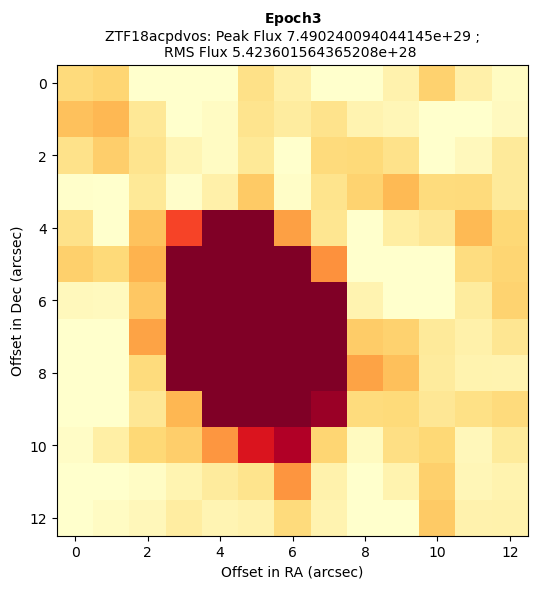

In [ ]:
image_lum_array('luminosity_arrays\ZTF18acpdvos_epoch_3_lum.npy')


In [275]:
import matplotlib.pyplot as plt
import numpy as np

def plot_flux_density(array, title="Flux Density Map"):
    plt.figure(figsize=(6, 6))
    
    # Compute robust min/max for color scaling
    vmin, vmax = np.percentile(array, [5, 95])  
    
    # Ensure contrast
    if vmin == vmax:
        vmin, vmax = np.min(array), np.max(array)
    
    plt.imshow(array, cmap='inferno', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(label="Flux Density")
    plt.title(title)
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")
    plt.show()


In [ ]:

temp3 = fits_to_luminosity_array('ZTF17aabtvsy', 'dillon_fits\ztf_cutouts\ztf_cutouts_no_interp\ZTF17aabtvsy_epoch_1.fits',
                         dataframe)[0]

In [380]:
temp3

masked_array(
  data=[[-2.749208040224e+26, 3.2135301982590147e+27,
         1.8720282422247488e+28, 8.585800655816387e+27,
         -1.0192671292895474e+28, -1.7537106621089003e+28,
         -2.0437243506156315e+28, -1.0798876678338623e+28,
         1.718510557224451e+28, 3.268970068482073e+28,
         1.5837201887220088e+27, -1.7222394370835965e+28,
         -2.140534867226647e+28],
        [-1.4153667602488297e+27, -6.252996617970846e+25,
         -4.542427283873998e+27, -1.4825529851060534e+28,
         -3.898133999429881e+27, 9.840701656435245e+27,
         1.2002780056178703e+28, 1.0700193523931896e+28,
         1.2015376422269561e+28, 1.6863804382852644e+28,
         -2.5671905119032936e+27, -2.8271326652582924e+28,
         -2.787872088321757e+28],
        [5.260140695756379e+26, -9.18158019430592e+27,
         -5.650887579821082e+27, -1.6414182837576487e+28,
         -1.3194837900527461e+28, 9.536963820626916e+27,
         1.2172382414234866e+28, 1.3854547961783926e+27,
     

In [ ]:
temp2 = np.load('D:\summer_research_code\Query_VLASS_2\ia_npy_luminosity_arrays\ZTF17aabtvsy_VLASS1.2v2_luminosity_array.npy')

luminosity_image_from_npy(temp3, 'yo', 'epoch 1', 300)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_19220\88387.py:1: SyntaxWarning: invalid escape sequence '\s'
  temp2 = np.load('D:\summer_research_code\Query_VLASS_2\ia_npy_luminosity_arrays\ZTF18acpdvos_VLASS1.2v2_luminosity_array.npy')
C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_19220\88387.py:1: SyntaxWarning: invalid escape sequence '\s'
  temp2 = np.load('D:\summer_research_code\Query_VLASS_2\ia_npy_luminosity_arrays\ZTF18acpdvos_VLASS1.2v2_luminosity_array.npy')


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\summer_research_code\\Query_VLASS_2\\ia_npy_luminosity_arrays\\ZTF18acpdvos_VLASS1.2v2_luminosity_array.npy'

In [247]:
import numpy as np
import matplotlib.pyplot as plt

def image_from_array(array, name, epoch):
    try:
        # Ensure the array is 2D
        if array.ndim != 2:
            print(f"Error: The input array for {name}, Epoch {epoch} must be 2D.")
            return None

        vmin = -1e-4
        vmax = 1e-3

        # Compute RMS using 3-sigma clipping
        rms_temp = np.std(array)
        keep = np.abs(array) <= 3 * rms_temp
        rms = np.std(array[keep])

        # Find peak flux
        peak_flux = np.max(array)

        # Get image size
        ny, nx = array.shape  # Should be 12x12

        # Plot image with adjusted scaling
        fig, ax = plt.subplots(figsize=(6, 6))
        img = ax.imshow(np.flipud(array), cmap='YlOrRd', vmin=vmin, vmax=vmax)

        # Format the title
        peakstr = f"Peak Flux: {np.round(peak_flux, 3)}"
        rmsstr = f"RMS Flux: {np.round(rms, 3)}"
        title_str = r'$\bf{%s}$' % epoch + '\n' + f'{name}; {peakstr}; {rmsstr}'
        ax.set_title(title_str, fontsize=10)

        # Label axes as pixel indices
        ax.set_xlabel("Pixel Index (RA Offset)")
        ax.set_ylabel("Pixel Index (Dec Offset)")
        ax.set_aspect('equal')  # Keep square aspect ratio

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {name}, Epoch {epoch}: {e}")
        return None
